[과제] bike_train.csv를 불어와서 다음 사항들을 고려하여 자전거 대여횟수를 예측하는 모델을 생성 후 평가하세요.

- datetime 타입에서 년, 월, 일, 시간 추출하여 반영 후 선형회귀 모델링 및 평가 
    - 사용자 함수 : RMSLE, RMSE, MAE
- 종속변수 정규성 개선위한 로그 변환
    - 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
    - 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할 
    - 선형회귀, ridge, lasso model 별로 평가 수행
    - 회귀계수 중요도 시각화


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bike_df=pd.read_csv('./dataset/bike_train.csv')
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
bike_df['datetime']=bike_df['datetime'].apply(pd.to_datetime)

In [4]:
bike_df['year']=bike_df['datetime'].apply(lambda x:x.year)
bike_df['month']=bike_df['datetime'].apply(lambda x:x.month)
bike_df['day']=bike_df['datetime'].apply(lambda x:x.day)
bike_df['hour']=bike_df['datetime'].apply(lambda x:x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [5]:
# count와 중복 컬럼
bike_df.drop(['datetime','casual','registered'],axis=1,inplace=True)

In [6]:
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


In [7]:
bike_df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439,-0.004797,0.971524,0.001729,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393,0.012021,0.001731,-0.015877,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594,-0.002482,-0.003394,0.009829,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655,-0.012548,0.012144,-0.007890,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.061226,0.257589,0.015551,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.058540,0.264173,0.011866,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,-0.078606,0.204537,-0.011335,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369,-0.015221,-0.150192,0.036157,0.146631
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000,0.260403,0.166862,0.019826,0.400601
year,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,0.260403,1.000000,-0.004932,0.001800,-0.004234


<AxesSubplot:>

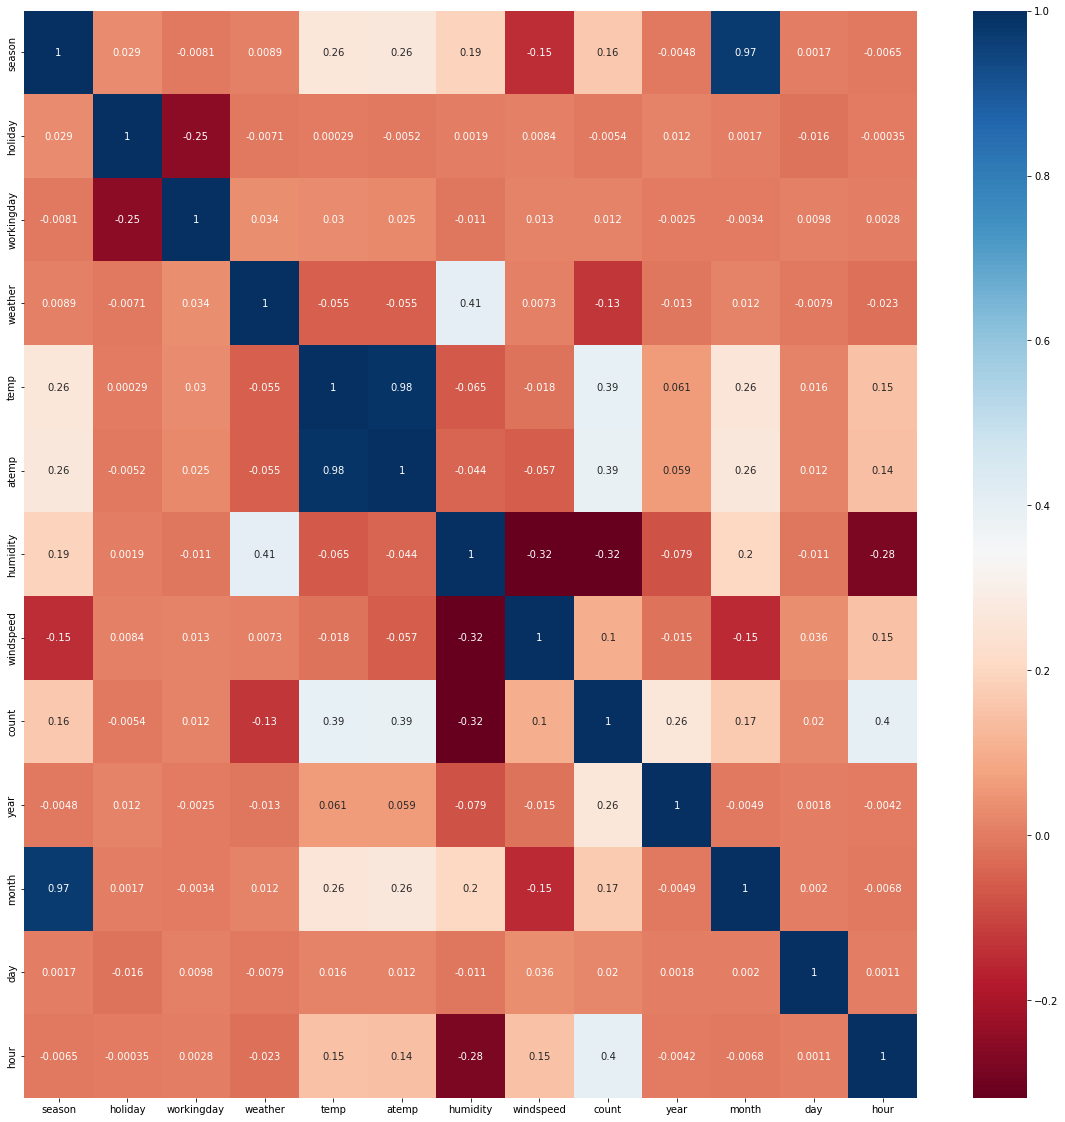

In [8]:
plt.figure(figsize=(20,20))
sns.heatmap(bike_df.corr(), cmap='RdBu',annot=True)

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# rmse = mean_squared_error(y_test, pred, squared = False)

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print("RMSLE: {0:.3f}, RMSE : {1:.3f}, MAE : {2:.3f}".format(rmsle_val, rmse_val, mae_val))

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE : 140.900, MAE : 105.924


C:\Users\qkrrh\AppData\Local\Temp/ipykernel_8096/2986640460.py:5: RuntimeWarning: invalid value encountered in log1p
  log_pred = np.log1p(pred)


In [11]:
def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    print(result_df.sort_values('diff', ascending = False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops = 5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

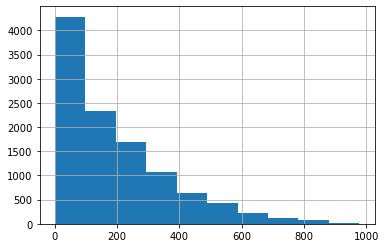

In [12]:
y_target.hist()

<AxesSubplot:>

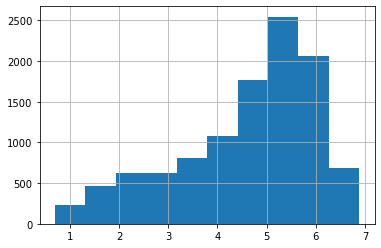

In [13]:
y_log_transform =  np.log1p(y_target)
y_log_transform.hist()

In [14]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state = 0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE : 162.594, MAE : 109.286


<AxesSubplot:>

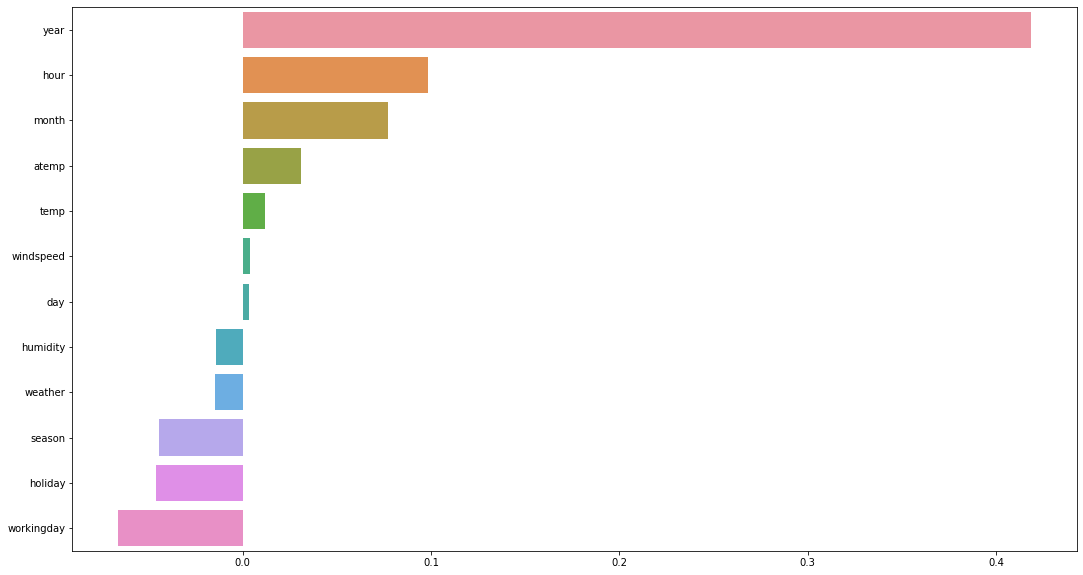

In [15]:
plt.figure(figsize=(18,10))
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x= coef_sort.values, y = coef_sort.index)

In [16]:
X_features_ohe = pd.get_dummies(X_features, columns = ['year','month','day','hour','holiday','workingday','season','weather'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state = 0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print(model.__class__.__name__)
    evaluate_regr(y_test, pred)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 10)
lasso_reg = Lasso(alpha = 0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

LinearRegression
RMSLE: 0.590, RMSE : 97.687, MAE : 63.382
Ridge
RMSLE: 0.590, RMSE : 98.529, MAE : 63.893
Lasso
RMSLE: 0.635, RMSE : 113.219, MAE : 72.803


<AxesSubplot:>

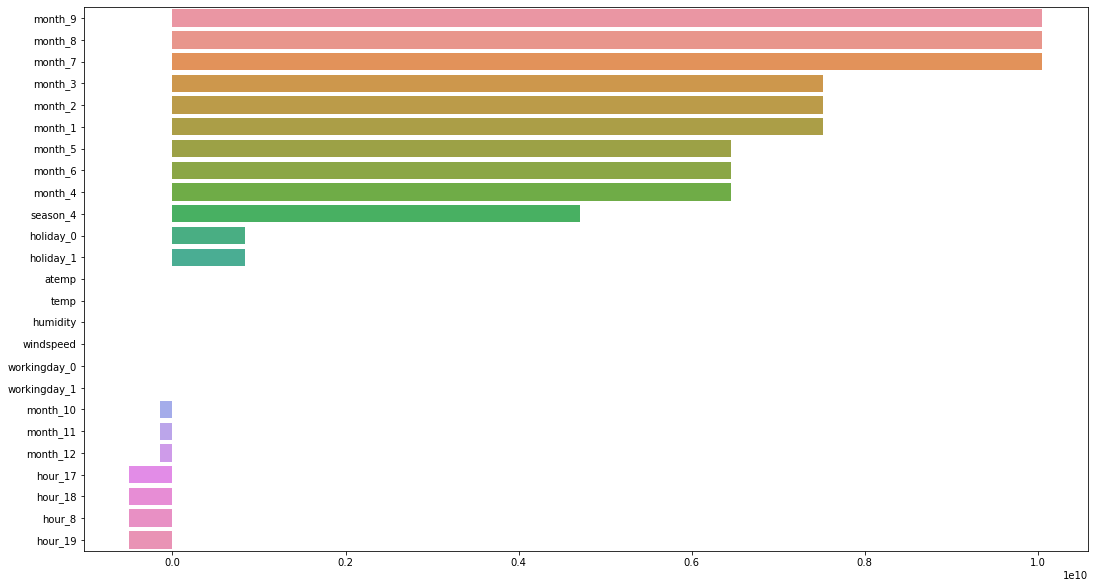

In [18]:
plt.figure(figsize=(18,10))
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending= False)[:25]
sns.barplot(x = coef_sort.values, y = coef_sort.index)

In [19]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg = GradientBoostingRegressor(n_estimators = 500)
xgb_reg = XGBRegressor(n_estimators = 500)
lgbm_reg = LGBMRegressor(n_estimators = 500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1= True)

RandomForestRegressor
RMSLE: 0.354, RMSE : 50.459, MAE : 31.177
GradientBoostingRegressor
RMSLE: 0.330, RMSE : 53.346, MAE : 32.752
XGBRegressor
RMSLE: 0.342, RMSE : 51.732, MAE : 31.251
LGBMRegressor
RMSLE: 0.319, RMSE : 47.215, MAE : 29.029
